In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Model, layers, models, optimizers, losses

2023-02-02 19:06:17.678593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 19:06:17.765911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 19:06:17.765928: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-02 19:06:18.369203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Reading the datasets

- dataset or HMF_theor.csv refers to the theoretical values obtained by a calculator assuming spheric colapse and LCDM.
- lcdm or lcdm_counts.dat contain data points from simulation assuming LCDM.

In [2]:
dataset_calc = pd.read_csv('data/HMF_theor.csv').drop(['Unnamed: 0'], axis=1)

lcdm = pd.read_csv('data/lcdm_counts.dat').drop(['Unnamed: 0'], axis = 1)

In [3]:
lcdm

,log_10(M200c),counts,n(>M)
0,10.572196,773,0.028888
1,10.877562,717,0.022704
2,11.182927,689,0.016968
3,11.488293,625,0.011456
4,11.793659,372,0.006456
5,12.099025,221,0.003480
6,12.404391,107,0.001712
7,12.709756,46,0.000856
8,13.015122,35,0.000488
9,13.320488,12,0.000208


In [4]:
dataset_calc

,log_10(mvir),n(>M)
0,1.000000e+10,2.543783e-01
1,1.122018e+10,2.298566e-01
2,1.258925e+10,2.077056e-01
3,1.412538e+10,1.876949e-01
4,1.584893e+10,1.696162e-01
...,...,...
95,5.623413e+14,1.997294e-06
96,6.309573e+14,1.556080e-06
97,7.079458e+14,1.199768e-06
98,7.943282e+14,9.146886e-07


# Comparison between the simulation and the calculator.

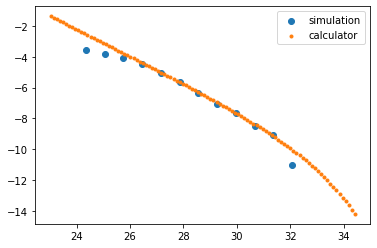

In [5]:
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='simulation')
plt.scatter(np.log(dataset_calc['log_10(mvir)']), np.log(dataset_calc['n(>M)']), label='calculator', marker='.')
plt.legend()

## Creating a method to generate a neural network model with keras.

In [6]:
def ann_model(ninput=1, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu',input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
#                   SGD(learning_rate=1e-4),#RMSprop(lr=0.001),
                        loss='mse',
                        metrics=['mse'])
    return model

# 1. Training a neural net with the data from calculator (dataset)

Using the log of the full dataset

In [7]:
dataset = np.log(dataset_calc)

In [8]:
np.max(dataset), np.min(dataset)

/home/isidro/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/isidro/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(log_10(mvir)    34.423647
 n(>M)           -1.368933
 dtype: float64,
 log_10(mvir)    23.025851
 n(>M)          -14.188168
 dtype: float64)

Standarization of the data

In [9]:
X = dataset.values[:, 0]
Y = dataset.values[:, 1]

xscaler = StandardScaler()
yscaler = StandardScaler()
# # fit scaler on data
xscaler.fit(X.reshape(-1, 1))
yscaler.fit(Y.reshape(-1, 1))
# # apply transform
X_sc = xscaler.transform(X.reshape(-1, 1))
Y_sc = yscaler.transform(Y.reshape(-1, 1))

Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_sc, Y_sc, test_size=0.1, random_state=42)

Generating a neural model for data from calculator:

In [11]:
neural_model_1 = ann_model(n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5)

neural_model_1_history = neural_model_1.fit(X_train, y_train, epochs=500, batch_size=32, 
                                            validation_data=(X_val,y_val))

Epoch 1/500


2023-02-02 19:06:44.899333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 19:06:44.899527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-02 19:06:44.899581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-02 19:06:44.899624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-02 19:06:44.899665: W tensorflow/c

3/3 [==============================] - 1s 60ms/step - loss: 0.9324 - mse: 0.9324 - val_loss: 0.7270 - val_mse: 0.7270
Epoch 2/500
3/3 [==============================] - 0s 10ms/step - loss: 0.9003 - mse: 0.9003 - val_loss: 0.7137 - val_mse: 0.7137
Epoch 3/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8558 - mse: 0.8558 - val_loss: 0.7008 - val_mse: 0.7008
Epoch 4/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9574 - mse: 0.9574 - val_loss: 0.6883 - val_mse: 0.6883
Epoch 5/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9312 - mse: 0.9312 - val_loss: 0.6755 - val_mse: 0.6755
Epoch 6/500
3/3 [==============================] - 0s 9ms/step - loss: 0.9606 - mse: 0.9606 - val_loss: 0.6633 - val_mse: 0.6633
Epoch 7/500
3/3 [==============================] - 0s 9ms/step - loss: 0.8925 - mse: 0.8925 - val_loss: 0.6517 - val_mse: 0.6517
Epoch 8/500
3/3 [==============================] - 0s 10ms/step - loss: 0.8871 - mse: 0.8871 - val_loss: 0

Epoch 64/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2992 - mse: 0.2992 - val_loss: 0.1026 - val_mse: 0.1026
Epoch 65/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2307 - mse: 0.2307 - val_loss: 0.0968 - val_mse: 0.0968
Epoch 66/500
3/3 [==============================] - 0s 10ms/step - loss: 0.2724 - mse: 0.2724 - val_loss: 0.0914 - val_mse: 0.0914
Epoch 67/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3109 - mse: 0.3109 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 68/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3596 - mse: 0.3596 - val_loss: 0.0809 - val_mse: 0.0809
Epoch 69/500
3/3 [==============================] - 0s 9ms/step - loss: 0.3023 - mse: 0.3023 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 70/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2934 - mse: 0.2934 - val_loss: 0.0723 - val_mse: 0.0723
Epoch 71/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2344 - mse: 0.2

3/3 [==============================] - 0s 9ms/step - loss: 0.1234 - mse: 0.1234 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 127/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2142 - mse: 0.2142 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 128/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1641 - mse: 0.1641 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 129/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1917 - mse: 0.1917 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 130/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1512 - mse: 0.1512 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 131/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1498 - mse: 0.1498 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 132/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1216 - mse: 0.1216 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 133/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1789 - mse: 0.1789 

3/3 [==============================] - 0s 10ms/step - loss: 0.1500 - mse: 0.1500 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 189/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1576 - mse: 0.1576 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 190/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1529 - mse: 0.1529 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 191/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1158 - mse: 0.1158 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 192/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1600 - mse: 0.1600 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 193/500
3/3 [==============================] - 0s 9ms/step - loss: 0.2182 - mse: 0.2182 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 194/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1607 - mse: 0.1607 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 195/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1526 - mse: 0.15

3/3 [==============================] - 0s 9ms/step - loss: 0.1296 - mse: 0.1296 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 251/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1567 - mse: 0.1567 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 252/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1218 - mse: 0.1218 - val_loss: 0.0186 - val_mse: 0.0186
Epoch 253/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1044 - mse: 0.1044 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 254/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1528 - mse: 0.1528 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 255/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1300 - mse: 0.1300 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 256/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1338 - mse: 0.1338 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 257/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1422 - mse: 0.1422 

3/3 [==============================] - 0s 10ms/step - loss: 0.1298 - mse: 0.1298 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 313/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 314/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1463 - mse: 0.1463 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 315/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1194 - mse: 0.1194 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 316/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1206 - mse: 0.1206 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 317/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1371 - mse: 0.1371 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 318/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1650 - mse: 0.1650 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 319/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1263 - mse: 0.1263 -

3/3 [==============================] - 0s 9ms/step - loss: 0.1388 - mse: 0.1388 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 375/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0990 - mse: 0.0990 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 376/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1095 - mse: 0.1095 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 377/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1599 - mse: 0.1599 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 378/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1061 - mse: 0.1061 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 379/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1126 - mse: 0.1126 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 380/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1220 - mse: 0.1220 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 381/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1217 - mse: 0.1217

3/3 [==============================] - 0s 9ms/step - loss: 0.1504 - mse: 0.1504 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 437/500
3/3 [==============================] - 0s 11ms/step - loss: 0.1245 - mse: 0.1245 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 438/500
3/3 [==============================] - 0s 13ms/step - loss: 0.1359 - mse: 0.1359 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 439/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0949 - mse: 0.0949 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 440/500
3/3 [==============================] - 0s 10ms/step - loss: 0.1099 - mse: 0.1099 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 441/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0725 - mse: 0.0725 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 442/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1043 - mse: 0.1043 - val_loss: 0.0175 - val_mse: 0.0175
Epoch 443/500
3/3 [==============================] - 0s 10ms/step - loss: 0.0987 - mse: 0.098

3/3 [==============================] - 0s 10ms/step - loss: 0.1189 - mse: 0.1189 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 499/500
3/3 [==============================] - 0s 9ms/step - loss: 0.1189 - mse: 0.1189 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 500/500
3/3 [==============================] - 0s 9ms/step - loss: 0.0954 - mse: 0.0954 - val_loss: 0.0176 - val_mse: 0.0176


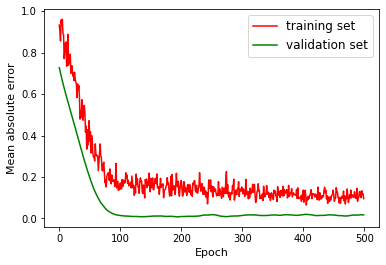

In [12]:
plt.plot(neural_model_1_history.history['mse'], color='r', )
plt.plot(neural_model_1_history.history['val_mse'], color='g')


plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [13]:
X_val = np.log(10**lcdm['log_10(M200c)'].values)
X_val_sc = xscaler.transform(X_val.reshape(-1,1))
ypred_sc = neural_model_1.predict(X_val_sc)
ypred = yscaler.inverse_transform(ypred_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

1/1 [==============================] - 0s 51ms/step
Traning and Testing on raw data, all features 



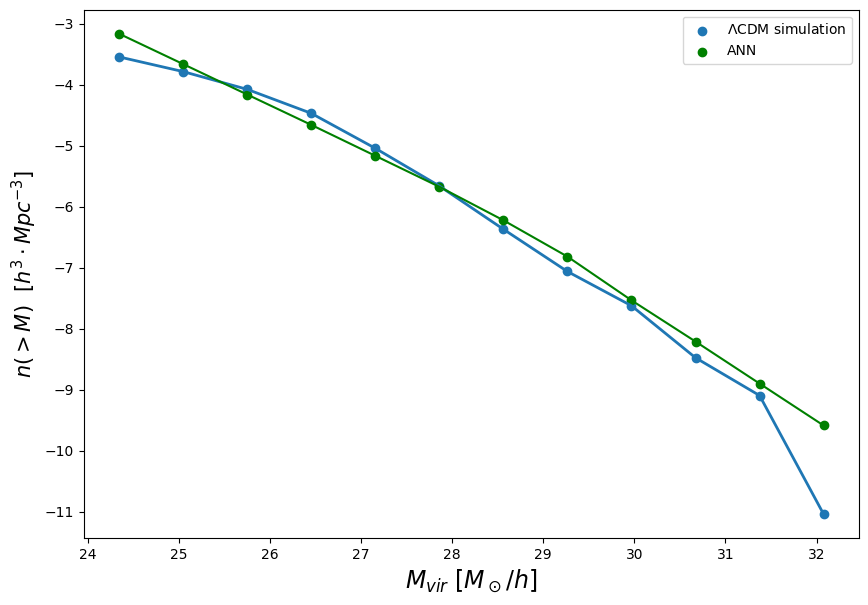

In [14]:
plt.figure(figsize=(10, 7), dpi=100)

# plt.yscale('log')
# plt.xscale('log')

plt.plot(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), linewidth=2)
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation')

plt.scatter(X_val, ypred, c='green', label='ANN')
plt.plot(X_val, ypred, c='green')


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

# plt.xlim([3.e10,2.e14])
# plt.ylim([1.e-6,1.e-1])
plt.legend()
plt.savefig('HMF_SFDM_extended.png')
plt.show()

# 2. Using the simulation data for training an ANN model.

Using log for the full dataset

In [15]:
data_sim = lcdm.values
# plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='simulation')


In [16]:
X_sim = np.log(10**data_sim[:, 0])
Y_sim = np.log(data_sim[:, 2])

xsim_scaler = StandardScaler()
ysim_scaler = StandardScaler()
# # fit scaler on data
xsim_scaler.fit(X_sim.reshape(-1, 1))
ysim_scaler.fit(Y_sim.reshape(-1, 1))
# # apply transform
X_sim_sc = xsim_scaler.transform(X_sim.reshape(-1, 1))
Y_sim_sc = ysim_scaler.transform(Y_sim.reshape(-1, 1))

In [17]:
Xsim_train, Xsim_val, ysim_train, ysim_val = train_test_split(X_sim_sc, Y_sim_sc, test_size=0.1, random_state=42)

In [18]:
neural_model_2 = ann_model(n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5)

neural_model_2_history = neural_model_2.fit(Xsim_train, ysim_train, epochs=500, batch_size=1, 
                                            validation_data=(Xsim_val,ysim_val))

Epoch 1/500
10/10 [==============================] - 1s 12ms/step - loss: 0.9379 - mse: 0.9379 - val_loss: 1.4823 - val_mse: 1.4823
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 1.0893 - mse: 1.0893 - val_loss: 1.4739 - val_mse: 1.4739
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8391 - mse: 0.8391 - val_loss: 1.4616 - val_mse: 1.4616
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 1.1092 - mse: 1.1092 - val_loss: 1.4616 - val_mse: 1.4616
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 0.6984 - mse: 0.6984 - val_loss: 1.4544 - val_mse: 1.4544
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8565 - mse: 0.8565 - val_loss: 1.4453 - val_mse: 1.4453
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 1.2551 - mse: 1.2551 - val_loss: 1.4431 - val_mse: 1.4431
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 1.1688 - 

10/10 [==============================] - 0s 3ms/step - loss: 0.6568 - mse: 0.6568 - val_loss: 0.7743 - val_mse: 0.7743
Epoch 64/500
10/10 [==============================] - 0s 3ms/step - loss: 0.5148 - mse: 0.5148 - val_loss: 0.7561 - val_mse: 0.7561
Epoch 65/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9578 - mse: 0.9578 - val_loss: 0.7312 - val_mse: 0.7312
Epoch 66/500
10/10 [==============================] - 0s 3ms/step - loss: 0.7843 - mse: 0.7843 - val_loss: 0.7191 - val_mse: 0.7191
Epoch 67/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4614 - mse: 0.4614 - val_loss: 0.7072 - val_mse: 0.7072
Epoch 68/500
10/10 [==============================] - 0s 3ms/step - loss: 0.5082 - mse: 0.5082 - val_loss: 0.6912 - val_mse: 0.6912
Epoch 69/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2273 - mse: 0.2273 - val_loss: 0.6803 - val_mse: 0.6803
Epoch 70/500
10/10 [==============================] - 0s 3ms/step - loss: 0.5861 - mse: 0

Epoch 125/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3767 - mse: 0.3767 - val_loss: 0.1517 - val_mse: 0.1517
Epoch 126/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.1455 - val_mse: 0.1455
Epoch 127/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2851 - mse: 0.2851 - val_loss: 0.1376 - val_mse: 0.1376
Epoch 128/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4763 - mse: 0.4763 - val_loss: 0.1329 - val_mse: 0.1329
Epoch 129/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1940 - mse: 0.1940 - val_loss: 0.1286 - val_mse: 0.1286
Epoch 130/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4603 - mse: 0.4603 - val_loss: 0.1223 - val_mse: 0.1223
Epoch 131/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3227 - mse: 0.3227 - val_loss: 0.1155 - val_mse: 0.1155
Epoch 132/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.1447 - mse: 0.1447 - val_loss: 4.4573e-04 - val_mse: 4.4573e-04
Epoch 187/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1560 - mse: 0.1560 - val_loss: 4.5632e-04 - val_mse: 4.5632e-04
Epoch 188/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2270 - mse: 0.2270 - val_loss: 5.1248e-04 - val_mse: 5.1248e-04
Epoch 189/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 5.4102e-04 - val_mse: 5.4102e-04
Epoch 190/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1588 - mse: 0.1588 - val_loss: 5.4337e-04 - val_mse: 5.4337e-04
Epoch 191/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1766 - mse: 0.1766 - val_loss: 8.2280e-04 - val_mse: 8.2280e-04
Epoch 192/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2401 - mse: 0.2401 - val_loss: 9.2226e-04 - val_mse: 9.2226e-04
Epoch 193/500
10/10 [======

10/10 [==============================] - 0s 3ms/step - loss: 0.1311 - mse: 0.1311 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 247/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0524 - mse: 0.0524 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 248/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2362 - mse: 0.2362 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 249/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0984 - mse: 0.0984 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 250/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1032 - mse: 0.1032 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 251/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2191 - mse: 0.2191 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 252/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1688 - mse: 0.1688 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 253/500
10/10 [==============================] - 0s 3ms/step - loss: 0.4469 -

Epoch 308/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2010 - mse: 0.2010 - val_loss: 0.0272 - val_mse: 0.0272
Epoch 309/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2970 - mse: 0.2970 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 310/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2161 - mse: 0.2161 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 311/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0655 - mse: 0.0655 - val_loss: 0.0315 - val_mse: 0.0315
Epoch 312/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1293 - mse: 0.1293 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 313/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2412 - mse: 0.2412 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 314/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1544 - mse: 0.1544 - val_loss: 0.0195 - val_mse: 0.0195
Epoch 315/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.2930 - mse: 0.2930 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 370/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3300 - mse: 0.3300 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 371/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0688 - mse: 0.0688 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 372/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1486 - mse: 0.1486 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 373/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1237 - mse: 0.1237 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 374/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2026 - mse: 0.2026 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 375/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3577 - mse: 0.3577 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 376/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1185 -

10/10 [==============================] - 0s 3ms/step - loss: 0.1423 - mse: 0.1423 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 431/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1371 - mse: 0.1371 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 432/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0695 - mse: 0.0695 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 433/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1957 - mse: 0.1957 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 434/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 435/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1296 - mse: 0.1296 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 436/500
10/10 [==============================] - 0s 3ms/step - loss: 0.2623 - mse: 0.2623 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 437/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3571 -

Epoch 491/500
10/10 [==============================] - 0s 3ms/step - loss: 0.3822 - mse: 0.3822 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 492/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0786 - mse: 0.0786 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 493/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1023 - mse: 0.1023 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 494/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 495/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1648 - mse: 0.1648 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 496/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0931 - mse: 0.0931 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 497/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1654 - mse: 0.1654 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 498/500
10/10 [==============================] - 0s 3ms/step - 

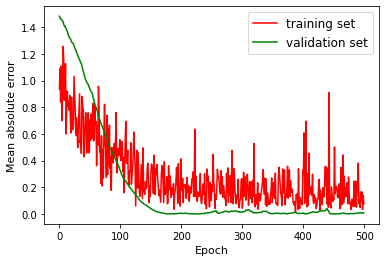

In [19]:
plt.plot(neural_model_2_history.history['mse'], color='r', )
plt.plot(neural_model_2_history.history['val_mse'], color='g')

plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [20]:
X_val2 = np.linspace(np.min(X_sim), np.max(X_sim), num=30)
X_val2_sc = xsim_scaler.transform(X_val2.reshape(-1,1))
ypred2_sc = neural_model_2.predict(X_val2_sc)
ypred2 = ysim_scaler.inverse_transform(ypred2_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

1/1 [==============================] - 0s 36ms/step
Traning and Testing on raw data, all features 



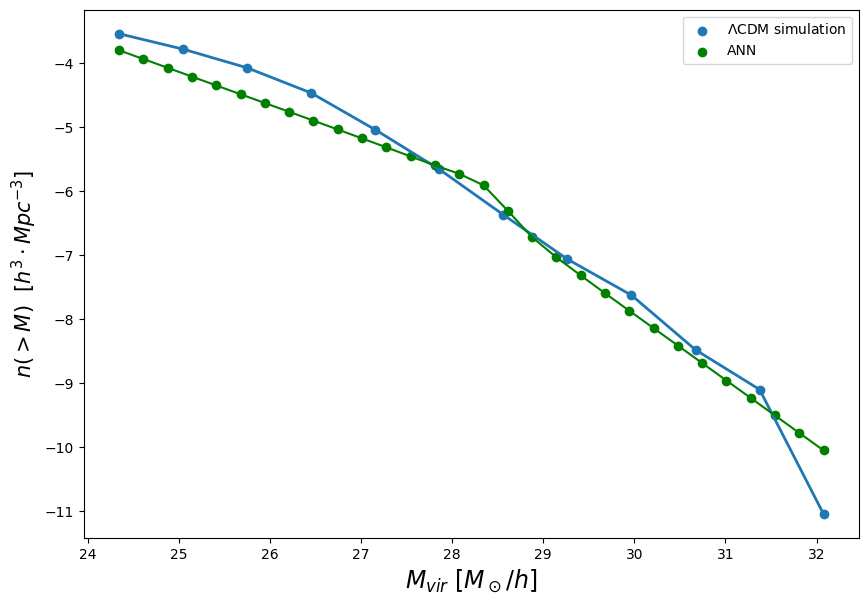

In [21]:
plt.figure(figsize=(10, 7), dpi=100)

plt.plot(X_sim, Y_sim, linewidth=2)
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation')

plt.scatter(X_val2, ypred2, c='green', label='ANN')
plt.plot(X_val2, ypred2, c='green')


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

# plt.xlim([3.e10,2.e14])
# plt.ylim([1.e-6,1.e-1])
plt.legend()
plt.savefig('HMF_sim_vs_ANN.png')
plt.show()

It is ok, but because it is a very small dataset the ANN does not learn the extremes values. So, following  	arXiv:2104.00595 (or https://github.com/igomezv/neuralCosmoReconstruction/blob/master/notebooks/ANN%20Hz.ipynb), we force to consider them:

In [22]:
data_sim = lcdm.values
shuffle = [x for x in range(len(data_sim)) if x%2 == 0]
comp = [x for x in range(len(data_sim)) if x%2 == 1]
comp.extend(shuffle)
data_sim = data_sim[comp]

In [23]:
lcdm.values == data_sim

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [24]:
data_sim

array([[1.08775617e+01, 7.17000000e+02, 2.27040000e-02],
       [1.14882933e+01, 6.25000000e+02, 1.14560000e-02],
       [1.20990249e+01, 2.21000000e+02, 3.48000000e-03],
       [1.27097565e+01, 4.60000000e+01, 8.56000000e-04],
       [1.33204881e+01, 1.20000000e+01, 2.08000000e-04],
       [1.39312197e+01, 2.00000000e+00, 1.60000000e-05],
       [1.05721959e+01, 7.73000000e+02, 2.88880000e-02],
       [1.11829275e+01, 6.89000000e+02, 1.69680000e-02],
       [1.17936591e+01, 3.72000000e+02, 6.45600000e-03],
       [1.24043907e+01, 1.07000000e+02, 1.71200000e-03],
       [1.30151223e+01, 3.50000000e+01, 4.88000000e-04],
       [1.36258539e+01, 1.20000000e+01, 1.12000000e-04]])

In [25]:
X_sim = np.log(10**data_sim[:, 0])
Y_sim = np.log(data_sim[:, 2])

xsim_scaler = StandardScaler()
ysim_scaler = StandardScaler()
# # fit scaler on data
xsim_scaler.fit(X_sim.reshape(-1, 1))
ysim_scaler.fit(Y_sim.reshape(-1, 1))
# # apply transform
X_sim_sc = xsim_scaler.transform(X_sim.reshape(-1, 1))
Y_sim_sc = ysim_scaler.transform(Y_sim.reshape(-1, 1))

In [26]:
# Xsim_train, Xsim_val, ysim_train, ysim_val = train_test_split(X_sim_sc, Y_sim_sc, test_size=0.1, shuffle=None)

In [27]:
split = 0.9
ntrain = int(split * len(X_sim_sc))
indx = [ntrain]
Xsim_train, Xsim_val = np.split(X_sim_sc, indx)
ysim_train, ysim_val = np.split(Y_sim_sc, indx)



In [28]:
neural_model_2 = ann_model(n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.2)

neural_model_2_history = neural_model_2.fit(Xsim_train, ysim_train, epochs=500, batch_size=1, 
                                            validation_data=(Xsim_val,ysim_val))

Epoch 1/500
10/10 [==============================] - 1s 10ms/step - loss: 0.9575 - mse: 0.9575 - val_loss: 0.8979 - val_mse: 0.8979
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9780 - mse: 0.9780 - val_loss: 0.8770 - val_mse: 0.8770
Epoch 3/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9476 - mse: 0.9476 - val_loss: 0.8531 - val_mse: 0.8531
Epoch 4/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9539 - mse: 0.9539 - val_loss: 0.8381 - val_mse: 0.8381
Epoch 5/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8340 - mse: 0.8340 - val_loss: 0.8175 - val_mse: 0.8175
Epoch 6/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8170 - mse: 0.8170 - val_loss: 0.7953 - val_mse: 0.7953
Epoch 7/500
10/10 [==============================] - 0s 3ms/step - loss: 0.8289 - mse: 0.8289 - val_loss: 0.7763 - val_mse: 0.7763
Epoch 8/500
10/10 [==============================] - 0s 3ms/step - loss: 0.9200 - 

10/10 [==============================] - 0s 3ms/step - loss: 0.1939 - mse: 0.1939 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 64/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0641 - mse: 0.0641 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 65/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 66/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 67/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1289 - mse: 0.1289 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 68/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1362 - mse: 0.1362 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 69/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0324 - mse: 0.0324 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 70/500
10/10 [==============================] - 0s 2ms/step - loss: 0.1014 - mse: 0

Epoch 125/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0612 - mse: 0.0612 - val_loss: 0.0782 - val_mse: 0.0782
Epoch 126/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0834 - mse: 0.0834 - val_loss: 0.0773 - val_mse: 0.0773
Epoch 127/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0835 - val_mse: 0.0835
Epoch 128/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0853 - val_mse: 0.0853
Epoch 129/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0365 - mse: 0.0365 - val_loss: 0.0879 - val_mse: 0.0879
Epoch 130/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0888 - mse: 0.0888 - val_loss: 0.0988 - val_mse: 0.0988
Epoch 131/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0911 - val_mse: 0.0911
Epoch 132/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.0924 - mse: 0.0924 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 187/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0756 - val_mse: 0.0756
Epoch 188/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1187 - mse: 0.1187 - val_loss: 0.0901 - val_mse: 0.0901
Epoch 189/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 0.0949 - val_mse: 0.0949
Epoch 190/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0208 - mse: 0.0208 - val_loss: 0.0994 - val_mse: 0.0994
Epoch 191/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.1036 - val_mse: 0.1036
Epoch 192/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.1079 - val_mse: 0.1079
Epoch 193/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0463 -

Epoch 248/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0965 - val_mse: 0.0965
Epoch 249/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0389 - mse: 0.0389 - val_loss: 0.0923 - val_mse: 0.0923
Epoch 250/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.1008 - val_mse: 0.1008
Epoch 251/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.1037 - val_mse: 0.1037
Epoch 252/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0216 - mse: 0.0216 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 253/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.1037 - val_mse: 0.1037
Epoch 254/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1146 - mse: 0.1146 - val_loss: 0.0994 - val_mse: 0.0994
Epoch 255/500
10/10 [==============================] - 0s 2ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.0762 - mse: 0.0762 - val_loss: 0.0468 - val_mse: 0.0468
Epoch 310/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 311/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 312/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0665 - val_mse: 0.0665
Epoch 313/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 314/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0387 - mse: 0.0387 - val_loss: 0.0588 - val_mse: 0.0588
Epoch 315/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0605 - val_mse: 0.0605
Epoch 316/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0510 -

Epoch 371/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 372/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 373/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 374/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0965 - val_mse: 0.0965
Epoch 375/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.0985 - val_mse: 0.0985
Epoch 376/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0568 - mse: 0.0568 - val_loss: 0.0877 - val_mse: 0.0877
Epoch 377/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0196 - mse: 0.0196 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 378/500
10/10 [==============================] - 0s 3ms/step - 

10/10 [==============================] - 0s 3ms/step - loss: 0.0569 - mse: 0.0569 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 433/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0578 - val_mse: 0.0578
Epoch 434/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0256 - mse: 0.0256 - val_loss: 0.0520 - val_mse: 0.0520
Epoch 435/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0620 - val_mse: 0.0620
Epoch 436/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0679 - val_mse: 0.0679
Epoch 437/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 438/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 439/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1270 -

Epoch 494/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 495/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0368 - mse: 0.0368 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 496/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 497/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0694 - mse: 0.0694 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 498/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0663 - mse: 0.0663 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 499/500
10/10 [==============================] - 0s 3ms/step - loss: 0.1130 - mse: 0.1130 - val_loss: 0.0485 - val_mse: 0.0485
Epoch 500/500
10/10 [==============================] - 0s 3ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.0510 - val_mse: 0.0510


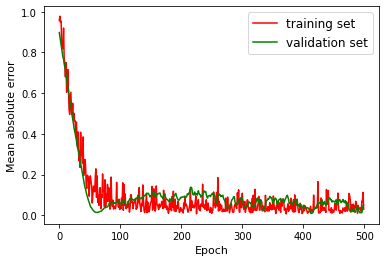

In [29]:
plt.plot(neural_model_2_history.history['mse'], color='r', )
plt.plot(neural_model_2_history.history['val_mse'], color='g')

plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [132]:
X_val2 = np.linspace(np.min(X_sim), np.max(X_sim), num=50)
X_val2_sc = xsim_scaler.transform(X_val2.reshape(-1,1))
ypred2_sc = neural_model_2.predict(X_val2_sc)
ypred2 = ysim_scaler.inverse_transform(ypred2_sc.reshape(-1,1))
#####
print('Traning and Testing on raw data, all features \n');

2/2 [==============================] - 0s 1ms/step
Traning and Testing on raw data, all features 



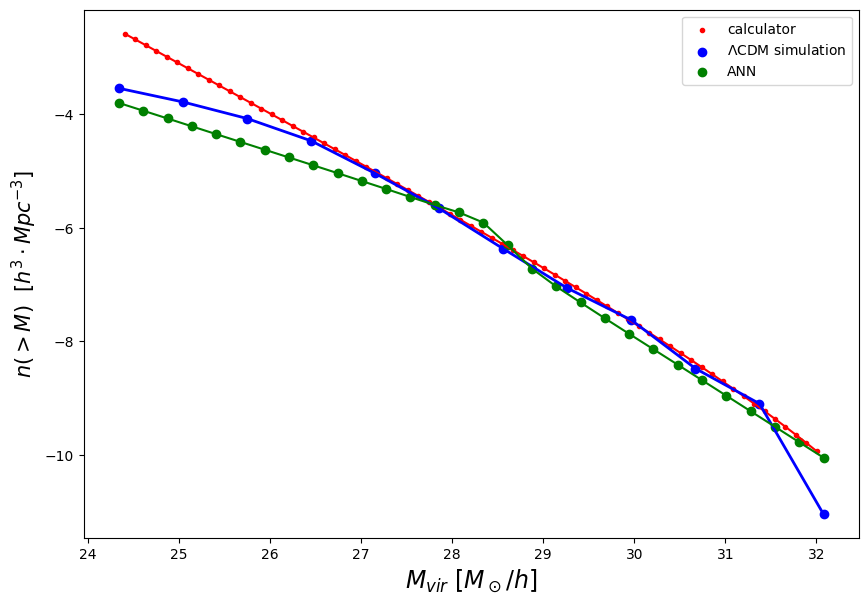

In [38]:
plt.figure(figsize=(10, 7), dpi=100)

boolArr = (dataset_calc_x >= np.min(X_val2)) & (dataset_calc_x <= np.max(X_val2))
dataset_calc_x = dataset_calc_x[boolArr]
dataset_calc_y = dataset_calc_y[boolArr]


plt.scatter(dataset_calc_x, dataset_calc_y, label='calculator', marker='.', c='red')
plt.plot(dataset_calc_x, dataset_calc_y, c='red')

plt.plot(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), linewidth=2, c='blue')
plt.scatter(np.log(10**lcdm['log_10(M200c)']), np.log(lcdm['n(>M)']), label='$\Lambda$CDM simulation', c='blue')

plt.scatter(X_val2, ypred2, c='green', label='ANN')
plt.plot(X_val2, ypred2, c='green')

dataset_calc_x = np.log(dataset_calc['log_10(mvir)'])
dataset_calc_y = np.log(dataset_calc['n(>M)'])


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

# plt.xlim([3.e10,2.e14])
# plt.ylim([1.e-6,1.e-1])
plt.legend()
plt.savefig('HMF_sim_vs_ANN2.png')
plt.show()